# Setup

In [1]:
import os
path = input("Enter the path:")
from google.colab import drive
drive.mount('/content/drive/')
os.chdir(path)

! pip install catboost
! pip install lightgbm
! pip install xgboost
! pip install bayesian-optimization
! pip install hyperopt


import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(style="darkgrid")
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pickle
#from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from statistics import mean
from collections import Counter
from imblearn.combine import SMOTEENN
import random
from xgboost import XGBClassifier
from sklearn.naive_bayes import ComplementNB
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
# from bayes_opt import BayesianOptimization
# import lightgbm as lgb
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

from sklearn.ensemble import StackingClassifier
import joblib
from sklearn.model_selection import KFold
from dask.distributed import Client
client = Client(processes=False)

Mounted at /content/drive/
     |████████████████████████████████| 66.2MB 56kB/s 
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=1173df766fd2f5cfcffdd2ea2c23f24d2276dd86de499ecc34091daa457cfe68
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


# Importing Data

In [ ]:
train = pd.read_csv("train.csv")

In [ ]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
train.shape

(54808, 14)

# Checking for missing values


In [ ]:
train.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [ ]:
train.isnull().sum()/train.shape[0] * 100

employee_id             0.000000
department              0.000000
region                  0.000000
education               4.395344
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    7.524449
length_of_service       0.000000
KPIs_met >80%           0.000000
awards_won?             0.000000
avg_training_score      0.000000
is_promoted             0.000000
dtype: float64

Only 7.5% of values are missing for previous_year_rating and 4.4% for education. Which means we will have to impute these values, rather than deleting the columns. Let us fill these values with 0.0 for previous year ratings and 'other' for education

In [ ]:
train['education'].fillna('null',inplace=True)
train['previous_year_rating'].fillna(0.0,inplace=True) 

In [ ]:
train.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

In [ ]:
print(train['education'].value_counts())
print(train['previous_year_rating'].value_counts())

Bachelor's          36669
Master's & above    14925
null                 2409
Below Secondary       805
Name: education, dtype: int64
3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
0.0     4124
Name: previous_year_rating, dtype: int64


# Feature Engineering

In [ ]:
train.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

In [ ]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


A few insights from EDA and observation:

1. KPIs_met >80%, awards_won? and is_promoted have only 2 unique values, these can be converted into categorical variables.

2. employee_id is an id, which won't provide us with insights

3. no_of_trainings: Maximum number of employees have completed only 1 training. This can be converted into a categorical variable,is_multiple_training_completed.

4. There are multiple sparse values for region, which we can merge.

We can uncover greater insights, from further analysis

We can also store the total count of employees having same region,gender,recruitment_channel and department, for each employee to see how those factors matter for promotion.

In [ ]:
columns = ['gender','region','department','recruitment_channel']

for column in columns:
  d = {}
  for value in train[column].unique():
    d[value] = train.loc[train[column] == value][column].shape[0]

  train[column+'_count'] = train[column].apply(lambda x:d[x])
  print(column)
  print(train[column+'_count'].value_counts())

gender
38496    38496
16312    16312
Name: gender_count, dtype: int64
region
12343    12343
6428      6428
4843      4843
2808      2808
2648      2648
2260      2260
1935      1935
1703      1703
1659      1659
1465      1465
1318      1318
1315      1315
1175      1175
994        994
945        945
874        874
850        850
827        827
819        819
796        796
766        766
690        690
657        657
655        655
648        648
610        610
508        508
500        500
420        420
411        411
346        346
292        292
269        269
31          31
Name: region_count, dtype: int64
department
16840    16840
7138     14276
11348    11348
5352      5352
2536      2536
2418      2418
1039      1039
999        999
Name: department_count, dtype: int64
recruitment_channel
30446    30446
23220    23220
1142      1142
Name: recruitment_channel_count, dtype: int64


In [ ]:
# Converting continuous variables to categorical
def convert_to_categorical(df,col):
  return df[col].apply(lambda x:str(x))

In [ ]:
train['KPIs_met >80%'] = convert_to_categorical(train,'KPIs_met >80%')
train['awards_won?'] = convert_to_categorical(train,'awards_won?')
train['is_promoted'] = convert_to_categorical(train,'is_promoted')

In [ ]:
#cat_col: name of categorical variable, cont_col:name of continuous variable
def cont_to_cat(df,cat_col,cont_col):
  temp = []
  no_rows = df.shape[0]
  print(no_rows)
  for i in range(0, no_rows):
    if int(df[cont_col][i]) > 1:
      temp.append(1)
    else:
      temp.append(0)
  
  # is_multiple_training_completed
  df[cat_col] = pd.Series(temp).astype('object')
  print(df[cat_col].value_counts())
  return df

In [ ]:
train = cont_to_cat(train,'is_multiple_training_completed','no_of_trainings')

54808
0    44378
1    10430
Name: is_multiple_training_completed, dtype: int64


From eda done earlier, we can infer that age and lenght of service don't provide much information, but they can be binned in order to do so. 

In [ ]:
bins = [-1,2,5,7,10,train['length_of_service'].max()]
labels = ['0-2','3-5','5-7','8-10','>10']
train['length_of_service_binned'] = pd.cut(train['length_of_service'], bins,labels=labels)


bins = [-1, 29, 39, 49,train['age'].max()]
labels = ['<30','30-39','40-49','>=50']
train['age_binned'] = pd.cut(train['age'], bins,labels=labels)

In [ ]:
train.drop(['employee_id'],axis=1,inplace=True)

In [ ]:
train.shape

(54808, 20)

In [ ]:
train.dtypes

department                          object
region                              object
education                           object
gender                              object
recruitment_channel                 object
no_of_trainings                      int64
age                                  int64
previous_year_rating               float64
length_of_service                    int64
KPIs_met >80%                       object
awards_won?                         object
avg_training_score                   int64
is_promoted                         object
gender_count                         int64
region_count                         int64
department_count                     int64
recruitment_channel_count            int64
is_multiple_training_completed      object
length_of_service_binned          category
age_binned                        category
dtype: object

In [ ]:
train.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,gender_count,region_count,department_count,recruitment_channel_count,is_multiple_training_completed,length_of_service_binned,age_binned
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,16312,4843,16840,23220,0,8-10,30-39
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,38496,6428,11348,30446,0,3-5,30-39
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,38496,874,16840,23220,0,5-7,30-39
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,38496,1175,16840,30446,1,8-10,30-39
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,38496,2260,7138,30446,0,0-2,40-49


In [ ]:
from pandas.api.types import is_numeric_dtype

In [ ]:
# For getting data types of dataframes
def get_dtypes(df):
  columns = df.columns
  num_cols = []
  cat_cols = []
  for column in columns:
    if (is_numeric_dtype(df[column])):
      num_cols.append(column) 
    else:
      cat_cols.append(column)

  return num_cols,cat_cols

In [ ]:
num_cols, cat_cols = get_dtypes(train)
# since is_promoted is a dependent variable and we will perform transformations on independent variables only, we remove it from cat_cols column and store it in target variable.
cat_cols.remove('is_promoted') 
target = 'is_promoted' 

In [ ]:
num_cols,cat_cols

(['no_of_trainings',
  'age',
  'previous_year_rating',
  'length_of_service',
  'avg_training_score',
  'gender_count',
  'region_count',
  'department_count',
  'recruitment_channel_count'],
 ['department',
  'region',
  'education',
  'gender',
  'recruitment_channel',
  'KPIs_met >80%',
  'awards_won?',
  'is_multiple_training_completed',
  'length_of_service_binned',
  'age_binned'])

In [ ]:
def get_unique_instances(df,cols):
  for i in range(0,len(cols)):
    print(str(cols[i]) + " - Number of Unique Values: " + str(df[cols[i]].nunique()))

In [ ]:
get_unique_instances(train,num_cols)

no_of_trainings - Number of Unique Values: 10
age - Number of Unique Values: 41
previous_year_rating - Number of Unique Values: 6
length_of_service - Number of Unique Values: 35
avg_training_score - Number of Unique Values: 61
gender_count - Number of Unique Values: 2
region_count - Number of Unique Values: 34
department_count - Number of Unique Values: 8
recruitment_channel_count - Number of Unique Values: 3


There are quite a few unique values for our numerical variables, hence we won't convert them to categorical variables.

In [ ]:
get_unique_instances(train,cat_cols)

department - Number of Unique Values: 9
region - Number of Unique Values: 34
education - Number of Unique Values: 4
gender - Number of Unique Values: 2
recruitment_channel - Number of Unique Values: 3
KPIs_met >80% - Number of Unique Values: 2
awards_won? - Number of Unique Values: 2
is_multiple_training_completed - Number of Unique Values: 2
length_of_service_binned - Number of Unique Values: 5
age_binned - Number of Unique Values: 4


1. There are many unique regions in the data, we will combine sparse classes for this attributes.
2. By peeking into data, we can infer that education,KPIs_met >80%,awards_won and is_multiple_training_completed are ordinal variables. We will have to perform label encoding for education. The rest are already in label encoded from(0's and 1's.)

In [ ]:
train['region'].value_counts() 

region_2     12343
region_22     6428
region_7      4843
region_15     2808
region_13     2648
region_26     2260
region_31     1935
region_4      1703
region_27     1659
region_16     1465
region_28     1318
region_11     1315
region_23     1175
region_29      994
region_32      945
region_19      874
region_20      850
region_14      827
region_25      819
region_17      796
region_5       766
region_6       690
region_30      657
region_8       655
region_10      648
region_1       610
region_24      508
region_12      500
region_9       420
region_21      411
region_3       346
region_34      292
region_33      269
region_18       31
Name: region, dtype: int64

We can group the regions according to the number of employees working at each region. Let' say we divide region into 2 parts, having employees > 2000 and less than 2000 into variable region_high_employees.

In [ ]:
more_than_2000 = ['region_2','region_22','region_7','region_15','region_13','region_26']

temp = []
no_rows = train.shape[0]
print(no_rows)
for i in range(0, no_rows):
  if train['region'][i] in more_than_2000:
    temp.append(1)
  else:
    temp.append(0)


train['region_high_employees'] = pd.Series(temp).astype('object')
print(train['region_high_employees'].value_counts())
print(train['region_high_employees'].value_counts(normalize=True))

54808
1    31330
0    23478
Name: region_high_employees, dtype: int64
1    0.571632
0    0.428368
Name: region_high_employees, dtype: float64


More than 57% of employees belong to 6 regions, while remaining 23 represent 43%. 

Region high employees is an ordinal variable, since it signifies the employee strength in a region. We will not need to label encode it since it's already in 0/1 format. 

In [ ]:
train.drop(['region'],axis=1,inplace=True)
cat_cols.append('region_high_employees')
cat_cols.remove('region')

In [ ]:
train.shape

(54808, 20)

## Encoding for categorical variables

In [ ]:
cat_cols

['department',
 'education',
 'gender',
 'recruitment_channel',
 'KPIs_met >80%',
 'awards_won?',
 'is_multiple_training_completed',
 'length_of_service_binned',
 'age_binned',
 'region_high_employees']

In [ ]:
train[cat_cols].head()

,department,education,gender,recruitment_channel,KPIs_met >80%,awards_won?,is_multiple_training_completed,length_of_service_binned,age_binned,region_high_employees
0,Sales & Marketing,Master's & above,f,sourcing,1,0,0,8-10,30-39,1
1,Operations,Bachelor's,m,other,0,0,0,3-5,30-39,1
2,Sales & Marketing,Bachelor's,m,sourcing,0,0,0,5-7,30-39,0
3,Sales & Marketing,Bachelor's,m,other,0,0,1,8-10,30-39,0
4,Technology,Bachelor's,m,other,0,0,0,0-2,40-49,1


In [ ]:
nominal = ['department','recruitment_channel','length_of_service_binned','age_binned','gender'] 
ordinal = ['education', 'KPIs_met >80%', 'awards_won?', 'is_multiple_training_completed', 'region_high_employees']

In [ ]:
def one_hot_encoding(data,cat_feats):
  one_hot = pd.get_dummies(data[cat_feats])
  one_hot = one_hot.astype('object')
  #print(one_hot.dtypes)
  data.drop(cat_feats,axis=1,inplace=True)
  data = pd.concat([data,one_hot],axis=1)
  return data

In [ ]:
train = one_hot_encoding(train,nominal)

In [ ]:
train.head()

,education,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,gender_count,region_count,department_count,recruitment_channel_count,is_multiple_training_completed,region_high_employees,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,length_of_service_binned_0-2,length_of_service_binned_3-5,length_of_service_binned_5-7,length_of_service_binned_8-10,length_of_service_binned_>10,age_binned_<30,age_binned_30-39,age_binned_40-49,age_binned_>=50,gender_f,gender_m
0,Master's & above,1,35,5.0,8,1,0,49,0,16312,4843,16840,23220,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,Bachelor's,1,30,5.0,4,0,0,60,0,38496,6428,11348,30446,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1
2,Bachelor's,1,34,3.0,7,0,0,50,0,38496,874,16840,23220,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,Bachelor's,2,39,1.0,10,0,0,50,0,38496,1175,16840,30446,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1
4,Bachelor's,1,45,3.0,2,0,0,73,0,38496,2260,7138,30446,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1


In [ ]:
train['education'].value_counts()

Bachelor's          36669
Master's & above    14925
null                 2409
Below Secondary       805
Name: education, dtype: int64

We can assign numeric values to education as follows:
0 - null
1 - Below Secondary
2- Bachelors
3 - Masters and above

In [ ]:
from sklearn.preprocessing import LabelEncoder
train['education'] = train['education'].map({'null':0,'Below Secondary':1,"Bachelor's":2,"Master's & above":3})
print(train['education'].value_counts())

2    36669
3    14925
0     2409
1      805
Name: education, dtype: int64


In [ ]:
train.shape

(54808, 38)

Since we've already converted the attributes into numerical form, let's also convert the attribute datatype to integer, which will make it easier to use for dimensionality reduction and modelling.

In [ ]:
train.dtypes

education                           int64
no_of_trainings                     int64
age                                 int64
previous_year_rating              float64
length_of_service                   int64
KPIs_met >80%                      object
awards_won?                        object
avg_training_score                  int64
is_promoted                        object
gender_count                        int64
region_count                        int64
department_count                    int64
recruitment_channel_count           int64
is_multiple_training_completed     object
region_high_employees              object
department_Analytics               object
department_Finance                 object
department_HR                      object
department_Legal                   object
department_Operations              object
department_Procurement             object
department_R&D                     object
department_Sales & Marketing       object
department_Technology             

In [ ]:
for variable in train.columns:
  if(train[variable].dtypes == "object"): 
    #print(variable)
    train[variable] = train[variable].apply(lambda x:int(x))

In [ ]:
# Since there are only 2 genders, male and female, one of gender_m and gender_f can represent the relevant information. 

#Dropping gender_f variable.
train.drop(['gender_f'],axis=1,inplace=True)

In [ ]:
train.dtypes

education                           int64
no_of_trainings                     int64
age                                 int64
previous_year_rating              float64
length_of_service                   int64
KPIs_met >80%                       int64
awards_won?                         int64
avg_training_score                  int64
is_promoted                         int64
gender_count                        int64
region_count                        int64
department_count                    int64
recruitment_channel_count           int64
is_multiple_training_completed      int64
region_high_employees               int64
department_Analytics                int64
department_Finance                  int64
department_HR                       int64
department_Legal                    int64
department_Operations               int64
department_Procurement              int64
department_R&D                      int64
department_Sales & Marketing        int64
department_Technology             

In [ ]:
train.shape

(54808, 37)

## Numerical variables processing


In [ ]:
num_cols

['no_of_trainings',
 'age',
 'previous_year_rating',
 'length_of_service',
 'avg_training_score',
 'gender_count',
 'region_count',
 'department_count',
 'recruitment_channel_count']

In [ ]:
train[num_cols].dtypes

no_of_trainings                int64
age                            int64
previous_year_rating         float64
length_of_service              int64
avg_training_score             int64
gender_count                   int64
region_count                   int64
department_count               int64
recruitment_channel_count      int64
dtype: object

In [ ]:
# changing previous_year_rating to int since it has discrete values
train['previous_year_rating'] = train['previous_year_rating'].apply(lambda x:int(x)) #train['previous_year_rating']

In [ ]:
train[num_cols].dtypes

no_of_trainings              int64
age                          int64
previous_year_rating         int64
length_of_service            int64
avg_training_score           int64
gender_count                 int64
region_count                 int64
department_count             int64
recruitment_channel_count    int64
dtype: object

In [ ]:
def plot_numerical(df_col):
  fig, axes = plt.subplots(nrows =1 , ncols=2, figsize=(12, 6))
  fig.tight_layout()
  ax1,ax2 = axes[0] , axes[1]  
  sns.boxplot(df_col, orient='vertical',ax=ax1)
  sns.distplot(df_col, kde = True, bins = 20, ax = ax2)
  plt.show()

For column name:  no_of_trainings


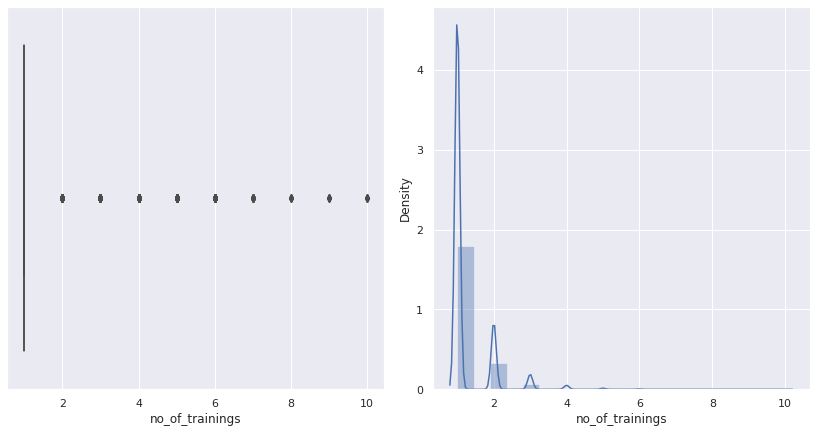

---------------------------------
For column name:  age


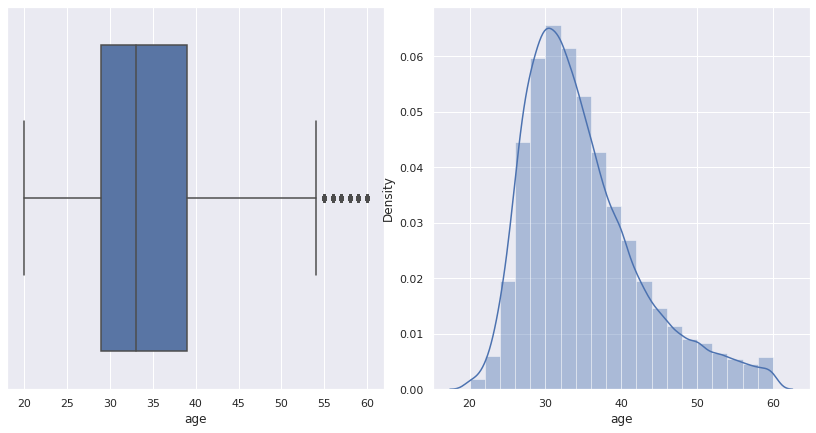

---------------------------------
For column name:  previous_year_rating


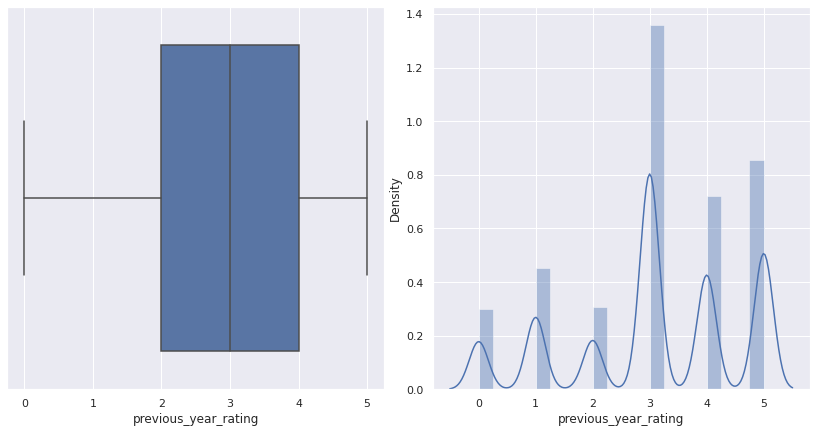

---------------------------------
For column name:  length_of_service


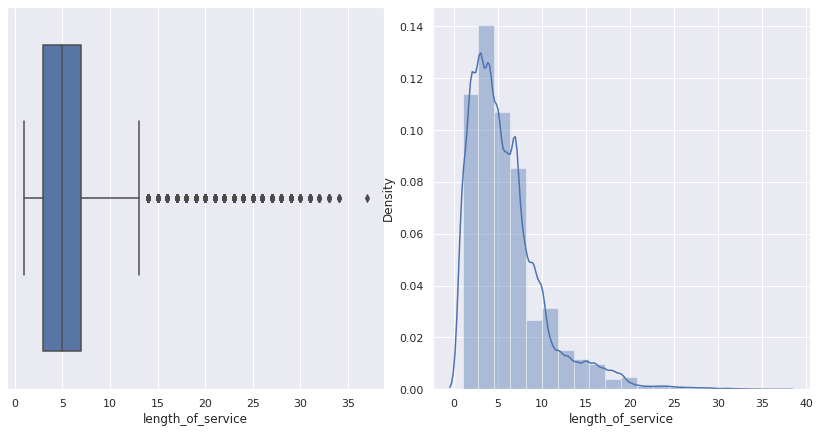

---------------------------------
For column name:  avg_training_score


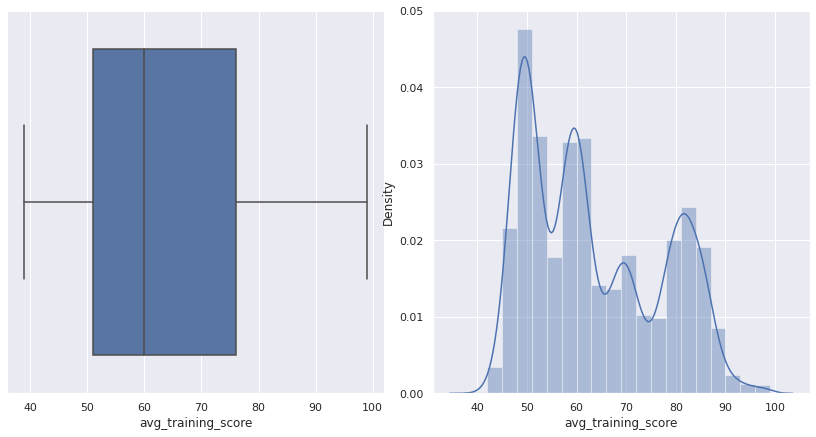

---------------------------------
For column name:  gender_count


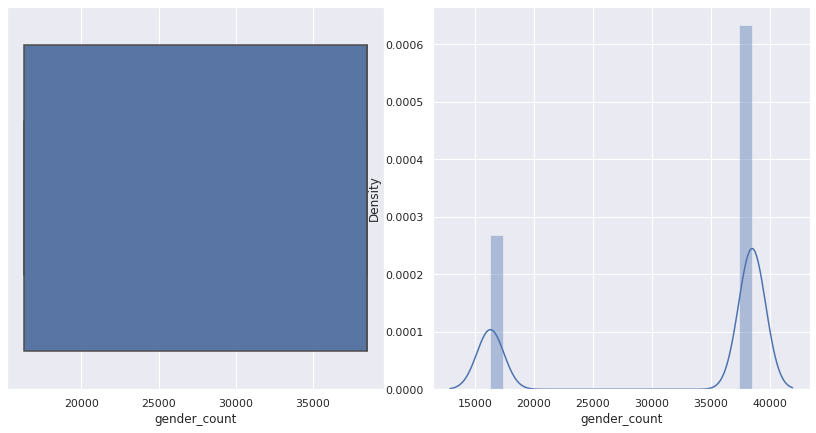

---------------------------------
For column name:  region_count


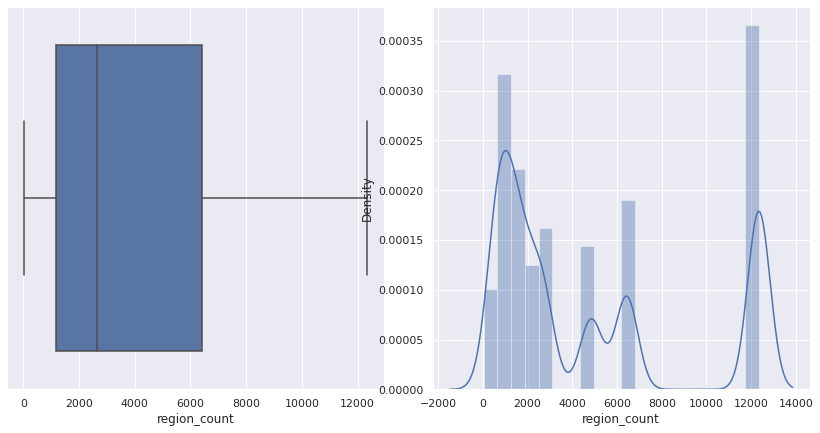

---------------------------------
For column name:  department_count


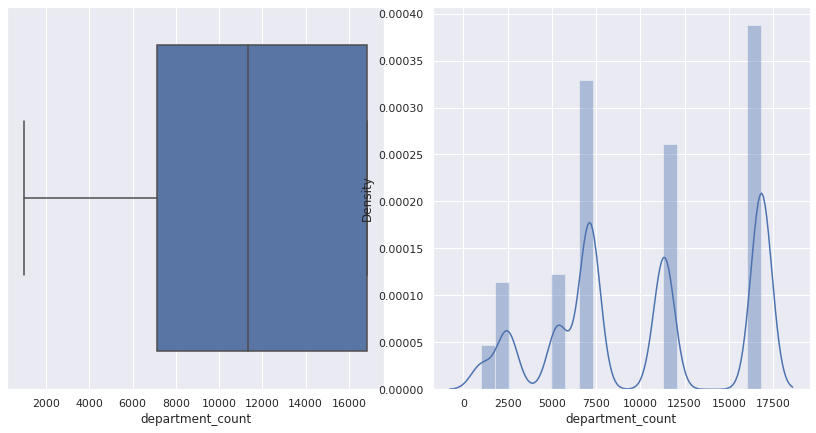

---------------------------------
For column name:  recruitment_channel_count


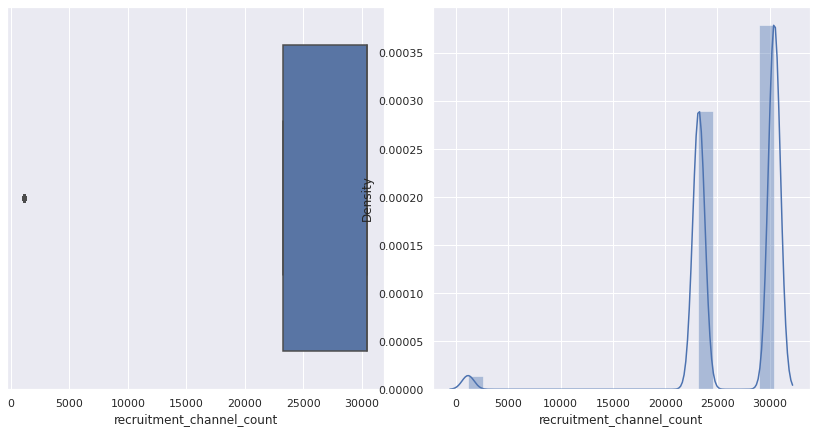

---------------------------------


In [ ]:
for col in num_cols:
  print("For column name: ",col)
  plot_numerical(train[col])
  print("---------------------------------")

All our numerical columns  can have genuine outliers(lower/higher values). 
Hence **we will not be processing outliers** in this case. 
Following can be induced for each variable from the above plots

1. previous_year_rating: The actual ratings are between 1 and 5, while 0 is a placeholder value for null values. No outliers(since all vals are between 0-5) and distribution is somewhat normal, so we do not require any transformations
3. avg_training_score: Training scores are between 40-100, hence outliers can be genuine.  The distribution is slightly right-skewed.

Let's scale the numeric variables and then visualize them again

In [ ]:
train_copy = train.copy()

In [ ]:
train.head()

,education,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,gender_count,region_count,department_count,recruitment_channel_count,is_multiple_training_completed,region_high_employees,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,length_of_service_binned_0-2,length_of_service_binned_3-5,length_of_service_binned_5-7,length_of_service_binned_8-10,length_of_service_binned_>10,age_binned_<30,age_binned_30-39,age_binned_40-49,age_binned_>=50,gender_m
0,3,1,35,5,8,1,0,49,0,16312,4843,16840,23220,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0
1,2,1,30,5,4,0,0,60,0,38496,6428,11348,30446,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1
2,2,1,34,3,7,0,0,50,0,38496,874,16840,23220,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1
3,2,2,39,1,10,0,0,50,0,38496,1175,16840,30446,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1
4,2,1,45,3,2,0,0,73,0,38496,2260,7138,30446,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1


Let's try log-transforming skewed variables(avg_training_score and no_of_trainings).

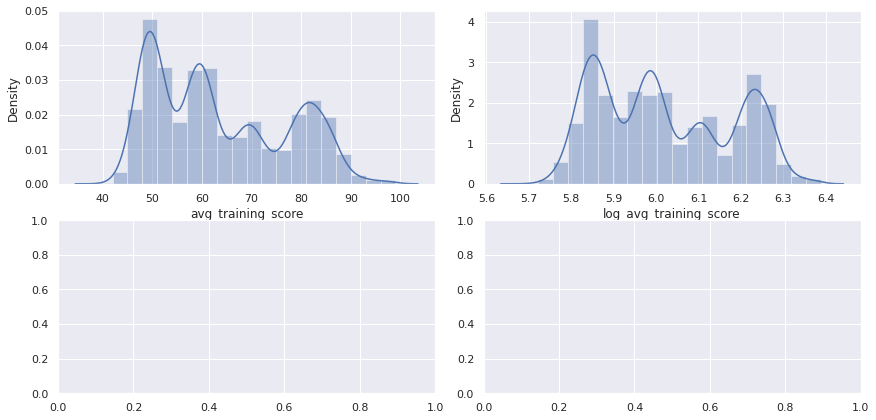

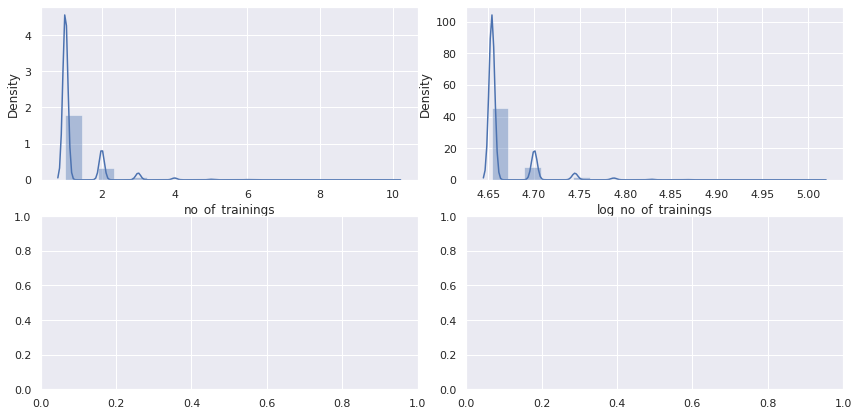

In [ ]:
train['log_avg_training_score'] = pd.DataFrame(np.log(train['avg_training_score'] * 5+ 100))

fig, axes = plt.subplots(nrows =2 , ncols=2, figsize=(12, 6))
fig.tight_layout()
ax1,ax2,ax3,ax4 = axes[0][0],axes[0][1],axes[1][0],axes[1][1]

sns.distplot(train['avg_training_score'], kde = True, bins = 20,ax=ax1)
sns.distplot(train['log_avg_training_score'],kde = True, bins = 20,ax=ax2)

train['log_no_of_trainings'] = pd.DataFrame(np.log(train['no_of_trainings'] * 5 + 100))

fig, axes = plt.subplots(nrows =2 , ncols=2, figsize=(12, 6))
fig.tight_layout()
ax1,ax2,ax3,ax4 = axes[0][0],axes[0][1],axes[1][0],axes[1][1]

sns.distplot(train['no_of_trainings'], kde = True, bins = 20,ax=ax1)
sns.distplot(train['log_no_of_trainings'],kde = True, bins = 20,ax=ax2)

From the above graphs, we can see that using log transform the right skewed variables have normalized to an extent. 

In [ ]:
num_cols

['no_of_trainings',
 'age',
 'previous_year_rating',
 'length_of_service',
 'avg_training_score',
 'gender_count',
 'region_count',
 'department_count',
 'recruitment_channel_count']

In [ ]:
to_add = ['log_no_of_trainings','log_avg_training_score']
to_drop = ['no_of_trainings','avg_training_score']
train.drop(to_drop,axis=1,inplace=True)

# changing num_cols values
for col in to_drop:
  num_cols.remove(col)

for col in to_add:
  num_cols.append(col)

print(num_cols)

['age', 'previous_year_rating', 'length_of_service', 'gender_count', 'region_count', 'department_count', 'recruitment_channel_count', 'log_no_of_trainings', 'log_avg_training_score']


In [ ]:
train[num_cols].isnull().sum()

age                          0
previous_year_rating         0
length_of_service            0
gender_count                 0
region_count                 0
department_count             0
recruitment_channel_count    0
log_no_of_trainings          0
log_avg_training_score       0
dtype: int64

# Splitting and Normalizing the data


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
## shuffle the DataFrame rows 
train = train.sample(frac = 1,random_state=100) 

Train:Test:Valid will be divided into 60:20:20 ratio

In [ ]:
X = train.drop([target],axis=1)
y = train[target]

#saving column names
columns = X.columns

#divide into train-valid and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 101, stratify=y,test_size=0.2)

#divide into train and valid sets
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train, random_state = 101, stratify=y_train,test_size=0.25)

In [ ]:
def min_max_normalization(df):
  return (df - df.min())/(df.max()-df.min())

In [ ]:
#retaining copy of old data
X_train_old = X_train.copy()
X_test_old = X_test.copy()
X_valid_old = X_valid.copy()
X_train[num_cols] = min_max_normalization(X_train[num_cols])
X_test[num_cols] = min_max_normalization(X_test[num_cols])
X_valid[num_cols] = min_max_normalization(X_valid[num_cols])

In [ ]:
X_train.shape,X_test.shape,X_valid.shape

((32884, 36), (10962, 36), (10962, 36))

In [ ]:
filename = 'X_train.sav'
pickle.dump(X_train, open(filename, 'wb'))

filename = 'X_test.sav'
pickle.dump(X_test, open(filename, 'wb'))

filename = 'X_valid.sav'
pickle.dump(X_valid, open(filename, 'wb'))

filename = 'y_train.sav'
pickle.dump(y_train, open(filename, 'wb'))

filename = 'y_test.sav'
pickle.dump(y_test, open(filename, 'wb'))

filename = 'y_valid.sav'
pickle.dump(y_valid, open(filename, 'wb'))

# Model Selection


If the difference between 2 classes is large, it's an imbalanced dataset.

In [ ]:
train[target].value_counts(normalize=True) * 100

0    91.482995
1     8.517005
Name: is_promoted, dtype: float64

Performing cross-validation to evaluate accuracy for different models.

0    91.482995

1     8.517005

Name: is_promoted, dtype: float64

In [ ]:
def check_clf(X,y,metric):

  clf_models = [ComplementNB(),LGBMClassifier(),CatBoostClassifier(verbose=0),LogisticRegression(class_weight='balanced'),DecisionTreeClassifier(class_weight='balanced'),SVC(class_weight='balanced'),
                RandomForestClassifier(class_weight='balanced'),AdaBoostClassifier(),XGBClassifier(scale_pos_weight=91.5,random_state=96)]
  
  clf_names = ['ComplementNB','LGBMClassifier','CatBoostClassifier','LogisticRegression','DecisionTreeClassifier','SVC','RandomForestClassifier','AdaBoostClassifier','XGBClassifier']
  
  results = []
  for clf in clf_models:
    #Using a numeric value for cv means that we'll be useing stratified k-fold cross validation
    scores = cross_val_score(clf, X, y, cv = 5, scoring=metric,n_jobs=-1)
    results.append(mean(scores))
  
  result_dict = {}
  
  for i in range(len(results)):
    print("Name: ",clf_names[i])
    print("Score: ",results[i])
    result_dict[clf_names[i]] = results[i] 

  return result_dict

We will use the f1 score to calculate the model performance, since avoiding both false positive(undeserving promotion) and false negatives(deserving employees not getting promoted) are equally improtant and we need a trade-off between precision and recall.

In [ ]:
results = check_clf(X_train,y_train,'f1_macro')

# save the model to disk
filename = 'train_cv_results.sav'
pickle.dump(results, open(filename, 'wb'))

results = check_clf(X_valid,y_valid,'f1_macro')

filename = 'valid_cv_results.sav'
pickle.dump(results, open(filename, 'wb'))

Name:  ComplementNB
Score:  0.5434514402295172
Name:  LGBMClassifier
Score:  0.7337354450311449
Name:  CatBoostClassifier
Score:  0.7392280202167181
Name:  LogisticRegression
Score:  0.614364463182136
Name:  DecisionTreeClassifier
Score:  0.6880293676420841
Name:  SVC
Score:  0.5917618292149386
Name:  RandomForestClassifier
Score:  0.6921911184765369
Name:  AdaBoostClassifier
Score:  0.6242053994148882
Name:  XGBClassifier
Score:  nan
Name:  ComplementNB
Score:  0.5408190452544918
Name:  LGBMClassifier
Score:  0.7195554329505993
Name:  CatBoostClassifier
Score:  0.7293787785262308
Name:  LogisticRegression
Score:  0.6072620860897355
Name:  DecisionTreeClassifier
Score:  0.6795107506510647
Name:  SVC
Score:  0.589704819462526
Name:  RandomForestClassifier
Score:  0.6474267780369812
Name:  AdaBoostClassifier
Score:  0.6248917031720144
Name:  XGBClassifier
Score:  nan


LGBM and Catboost are the 2 best performing algorithms on train and validation set. We'll try the 2 of them individually and then combine them to form an ensemble model. 

# Loading Train,Test and Valid sets

In [2]:
filename = 'X_train.sav'
X_train = pickle.load(open(filename, 'rb'))

filename = 'X_test.sav'
X_test = pickle.load(open(filename, 'rb'))

filename = 'X_valid.sav'
X_valid = pickle.load(open(filename, 'rb'))

filename = 'y_train.sav'
y_train = pickle.load(open(filename, 'rb'))

filename = 'y_test.sav'
y_test = pickle.load(open(filename, 'rb'))

filename = 'y_valid.sav'
y_valid = pickle.load(open(filename, 'rb'))

# Note: The dataset will be trained on train set and then validated on validation set. The test set will be used to compare performance with validation set to see if we haven't overfitted on validation set. Our goal is to keep the performance almost similar on all 3 sets, to ensure a better generalized model.

# Helper functions

In [3]:
#Check performance of model 
def check_clf_score(clf):
  clf.fit(X_train,y_train)
  y_train_pred = clf.predict(X_train)
  y_valid_pred =  clf.predict(X_valid)

  train_score = f1_score(y_train, y_train_pred, average='macro')
  valid_score = f1_score(y_valid, y_valid_pred, average='macro')

  print("Training score: ",train_score)
  print("valid score: ",valid_score)

  y_test_pred =  clf.predict(X_test)
  test_score = f1_score(y_test, y_test_pred, average='macro')
  print("test score: ",test_score)

  print("\n For train set \n")
  print("Actual value counts")
  print(y_train.value_counts())
  print("Predicted value counts")
  print(pd.Series(y_train_pred).value_counts())

  print("\n For validation set \n")
  print("Actual value counts")
  print(y_valid.value_counts())
  print("Predicted value counts")
  print(pd.Series(y_valid_pred).value_counts())
  
  print("\n For test set \n")
  print("Actual value counts")
  print(y_test.value_counts())
  print("Predicted value counts")
  print(pd.Series(y_test_pred).value_counts())
  return y_train_pred,y_valid_pred,y_test_pred

In [4]:
def get_optimal_f1_thresh(target, oofs):
  thresholds = np.arange(0, 100)/100
  thresh_scores = []
  for thresh in thresholds:
    oofs_rounded = (oofs > thresh) * 1
    thresh_score = f1_score(target, oofs_rounded,average='macro')
    thresh_scores.append(thresh_score)
  
  all_thresholds_and_scores = pd.Series(index = thresholds, data = thresh_scores)
  all_thresholds_and_scores.plot(figsize=(10, 6), fontsize=14)
  
  plt.xlabel('Threshold', fontsize=14)
  plt.ylabel('F1 Score', fontsize=14)
  print("Best Threshold: ",all_thresholds_and_scores.sort_values(ascending=False).index.values[0])
  print("Best Score: ",all_thresholds_and_scores.sort_values(ascending=False)[0])
  #print(all_thresholds_and_scores.sort_values(ascending=False))
  #return all_thresholds_and_scores.sort_values(ascending=False).index.values[0]

In [5]:
from sklearn.model_selection import RandomizedSearchCV

def random_search(clf,params,model_name,num_iter):
  #clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)
  randomsearch = RandomizedSearchCV(estimator=clf, param_distributions=params, n_iter= num_iter, cv=5, scoring = 'f1_macro',n_jobs = -1)
  randomsearch.fit(X_train,y_train)
  #clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)
  best_params = randomsearch.best_params_
  filename = model_name+'_best_params.sav'
  pickle.dump(best_params, open(filename, 'wb'))
  return best_params

In [6]:
def run_gradient_boosting(clf,fit_params,X_trn,y_trn,X_val,y_val):
  _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

  ### Instead of directly predicting the classes we will obtain the probability of positive class.
  preds_train = clf.predict_proba(X_train)[:, 1]
  preds_valid = clf.predict_proba(X_val)[:, 1]
  return preds_train,preds_valid

# Catboost


In [ ]:
clf = CatBoostClassifier(verbose=0)
y_train_pred,y_valid_pred,y_test_pred = check_clf_score(clf)

Training score:  0.7800817579750599
valid score:  0.7363721295422925
test score:  0.7313465756614016

 For train set 

Actual value counts
0    30084
1     2800
Name: is_promoted, dtype: int64
Predicted value counts
0    31703
1     1181
dtype: int64

 For validation set 

Actual value counts
0    10028
1      934
Name: is_promoted, dtype: int64
Predicted value counts
0    10602
1      360
dtype: int64

 For test set 

Actual value counts
0    10028
1      934
Name: is_promoted, dtype: int64
Predicted value counts
0    10632
1      330
dtype: int64


In [ ]:
params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000], 
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100], 
          'border_count':[32,5,10,20,50,100,200]}

clf = CatBoostClassifier(verbose=0)
catboost_params = random_search(clf,params,'catboost',80)

In [ ]:
filename = 'catboost_best_params.sav'
catboost_params = pickle.load(open(filename, 'rb'))
print(catboost_params)

{'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 3, 'border_count': 200}


In [ ]:
clf = CatBoostClassifier(verbose=0,**catboost_params)
y_train_pred,y_valid_pred,y_test_pred = check_clf_score(clf)

Training score:  0.753498837940703
valid score:  0.7353864067484863
test score:  0.7307267953288702

 For train set 

Actual value counts
0    30084
1     2800
Name: is_promoted, dtype: int64
Predicted value counts
0    31804
1     1080
dtype: int64

 For validation set 

Actual value counts
0    10028
1      934
Name: is_promoted, dtype: int64
Predicted value counts
0    10605
1      357
dtype: int64

 For test set 

Actual value counts
0    10028
1      934
Name: is_promoted, dtype: int64
Predicted value counts
0    10633
1      329
dtype: int64


In [ ]:
#save columns selected, since we selected all columns, we'll save the columns variables selected earlier
filename = 'columns_selected'
pickle.dump(columns, open(filename, 'wb'))

## F1 score optimization

In [ ]:
clf = CatBoostClassifier(verbose=0,**catboost_params)
fit_params = {'verbose': 100, 'early_stopping_rounds': 100}
y_train_pred, y_valid_pred = run_gradient_boosting(clf, fit_params, X_train,y_train,X_valid,y_valid)

0:	learn: 0.5881014	test: 0.5881932	best: 0.5881932 (0)	total: 64.3ms	remaining: 1m 4s
100:	learn: 0.1736753	test: 0.1762392	best: 0.1762392 (100)	total: 1.27s	remaining: 11.3s
200:	learn: 0.1641116	test: 0.1689318	best: 0.1689318 (200)	total: 2.47s	remaining: 9.81s
300:	learn: 0.1595009	test: 0.1665634	best: 0.1665613 (288)	total: 3.7s	remaining: 8.59s
400:	learn: 0.1566775	test: 0.1659078	best: 0.1659078 (400)	total: 4.93s	remaining: 7.37s
500:	learn: 0.1543749	test: 0.1653255	best: 0.1651892 (465)	total: 6.22s	remaining: 6.19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1651892007
bestIteration = 465

Shrink model to first 466 iterations.


Best Threshold:  0.24
Best Score:  0.07846653962560252


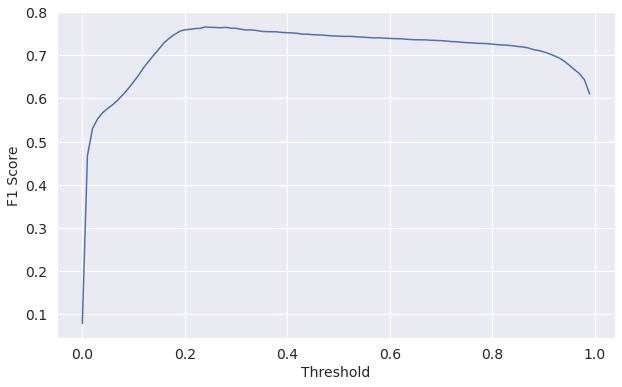

In [ ]:
get_optimal_f1_thresh(y_train, y_train_pred)

Best Threshold:  0.34
Best Score:  0.0785137861466039


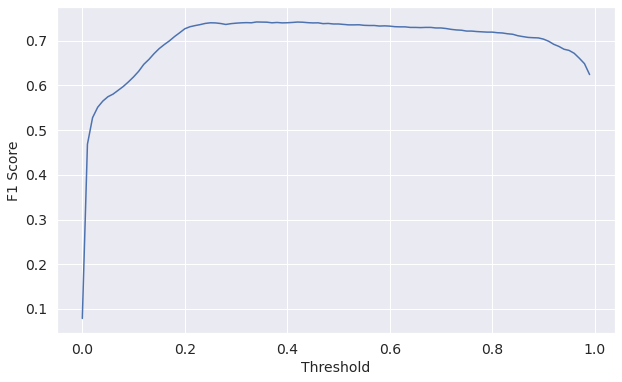

In [ ]:
get_optimal_f1_thresh(y_valid, y_valid_pred)

Looking at the graphs above, we can select 0.25 as optimal threshold 

In [ ]:
y_test_pred =  clf.predict_proba(X_test)[:, 1]
optimal_thresh = 0.25
y_test_pred_rounded = (y_test_pred > optimal_thresh) * 1
test_score = f1_score(y_test, y_test_pred_rounded, average='macro')

In [ ]:
print(test_score)

0.7406543714388205


The train,test and valid scores are all between 0.75 and 0.8. Therefore, we can say that the proper parameters have been selected.

# LightGBM


In [ ]:
clf = LGBMClassifier(class_weight='balanced')
y_train_pred,y_valid_pred,y_test_pred = check_clf_score(clf)

Training score:  0.6591915637261279
valid score:  0.6221147951436458
test score:  0.6227641459955249

 For train set 

Actual value counts
0    30084
1     2800
Name: is_promoted, dtype: int64
Predicted value counts
0    23510
1     9374
dtype: int64

 For validation set 

Actual value counts
0    10028
1      934
Name: is_promoted, dtype: int64
Predicted value counts
0    7722
1    3240
dtype: int64

 For test set 

Actual value counts
0    10028
1      934
Name: is_promoted, dtype: int64
Predicted value counts
0    7734
1    3228
dtype: int64


## Hyperparameter Tuning

In [ ]:
params = {
    'boosting_type':['gbdt','goss','dart','rf'],
    'n_estimators': [250,500,750,1000],
    'num_leaves': [75,100,150,200],
    'learning_rate': [0.01,0.1,0.5,1],
    'max_depth': [6,8,10,12,14],
    'colsample_bytree':[0.5,0.75,1]
}

In [ ]:
clf = LGBMClassifier(class_weight='balanced')
lgbm_params = random_search(clf,params,'lgbm',40)

In [ ]:
filename = 'lgbm_best_params.sav'
lgbm_params = pickle.load(open(filename, 'rb'))
print(lgbm_params) 

{'num_leaves': 150, 'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.5, 'colsample_bytree': 0.75, 'boosting_type': 'gbdt'}


In [ ]:
clf = LGBMClassifier(class_weight='balanced',**lgbm_params)
y_train_pred,y_valid_pred,y_test_pred = check_clf_score(clf) 

Training score:  0.9998048716413923
valid score:  0.7155812053616821
test score:  0.7094399119947037

 For train set 

Actual value counts
0    30084
1     2800
Name: is_promoted, dtype: int64
Predicted value counts
0    30082
1     2802
dtype: int64

 For validation set 

Actual value counts
0    10028
1      934
Name: is_promoted, dtype: int64
Predicted value counts
0    10281
1      681
dtype: int64

 For test set 

Actual value counts
0    10028
1      934
Name: is_promoted, dtype: int64
Predicted value counts
0    10316
1      646
dtype: int64


## F1 score optimization

In [ ]:
# lgb_params = {'num_leaves': 150, 'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.5, 'colsample_bytree': 0.75, 'boosting_type': 'gbdt'}
clf = LGBMClassifier(class_weight='balanced',**lgbm_params)
fit_params = {'verbose': 100, 'early_stopping_rounds': 100}
y_train_pred, y_valid_pred = run_gradient_boosting(clf, fit_params, X_train,y_train,X_valid,y_valid)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.29314
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.261204


Best Threshold:  0.77
Best Score:  0.07846653962560252


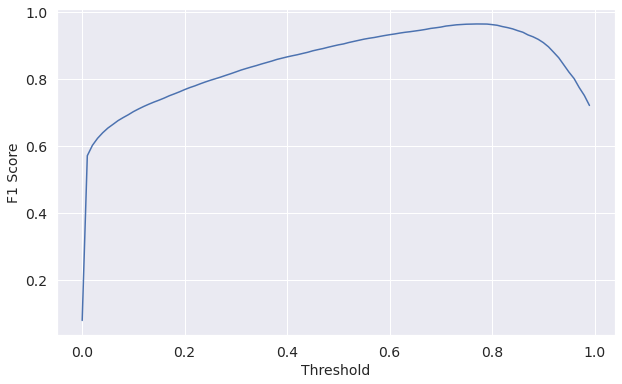

In [ ]:
get_optimal_f1_thresh(y_train, y_train_pred)

Best Threshold:  0.9
Best Score:  0.0785137861466039


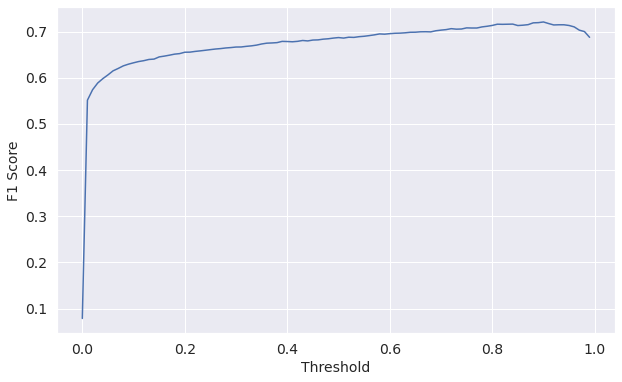

In [ ]:
get_optimal_f1_thresh(y_valid, y_valid_pred)

Based on above graphs, we can see that the threshold of 0.9 is the best one

In [ ]:
y_test_pred =  clf.predict_proba(X_test)[:, 1]
optimal_thresh = 0.9
y_test_pred_rounded = (y_test_pred > optimal_thresh) * 1
test_score = f1_score(y_test, y_test_pred_rounded, average='macro')
print(test_score)

0.7101625886801899


# Ensembling

In [ ]:
filename = 'lgbm_best_params.sav'
lgbm_params = pickle.load(open(filename, 'rb'))
clf1 = LGBMClassifier(class_weight='balanced',**lgbm_params)

filename = 'catboost_best_params.sav'
catboost_params = pickle.load(open(filename, 'rb'))
clf2 = CatBoostClassifier(verbose=0,**catboost_params)

In [ ]:
estimators = [('lgbm', clf1),('catboost', clf2)]

In [ ]:
results = {}
with joblib.parallel_backend('dask'):
  models = [LGBMClassifier(),CatBoostClassifier(verbose=0),XGBClassifier(random_state=96)]  
  model_names = ['LGBMClassifier','CatBoostClassifier','XGBClassifier']
  for i in range(len(models)):
    clf = StackingClassifier(estimators=estimators, final_estimator=models[i]) 
    results[model_names[i]] = mean(cross_val_score(clf, X_train, y_train, cv = 5, scoring='f1_macro',n_jobs=-1))

print(results)

{'LGBMClassifier': 0.7357683941001592, 'CatBoostClassifier': 0.7357319985046848, 'XGBClassifier': 0.7352476637666098}


In [ ]:
results = {}
with joblib.parallel_backend('dask'):
  models = [LGBMClassifier(),CatBoostClassifier(verbose=0),XGBClassifier(random_state=96)]  
  model_names = ['LGBMClassifier','CatBoostClassifier','XGBClassifier']
  for i in range(len(models)):
    clf = StackingClassifier(estimators=estimators, final_estimator=models[i]) 
    results[model_names[i]] = mean(cross_val_score(clf, X_valid, y_valid, cv = 5, scoring='f1_macro',n_jobs=-1))

print(results)

{'LGBMClassifier': 0.7281009298960412, 'CatBoostClassifier': 0.7228913853738546, 'XGBClassifier': 0.7198900812857514}


In [ ]:
clf = StackingClassifier(estimators=estimators, final_estimator = LGBMClassifier())
clf.fit(X_train,y_train)
y_train_pred = clf.predict_proba(X_train)[:, 1]
y_valid_pred = clf.predict_proba(X_valid)[:, 1]

Best Threshold:  0.26
Best Score:  0.07846653962560252


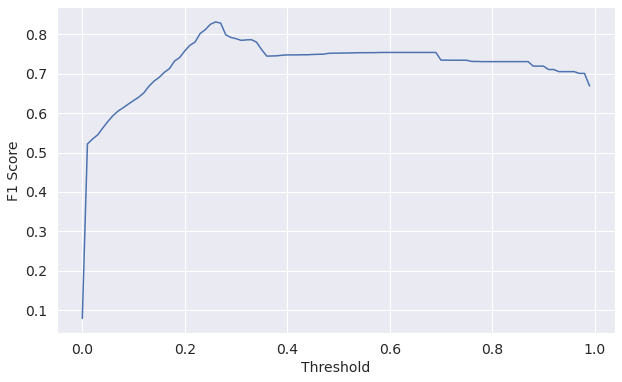

In [ ]:
get_optimal_f1_thresh(y_train, y_train_pred)

Best Threshold:  0.4
Best Score:  0.0785137861466039


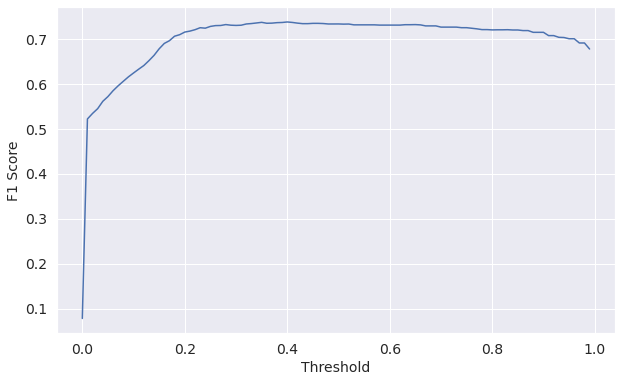

In [ ]:
get_optimal_f1_thresh(y_valid, y_valid_pred)

0.4 seems like the ideal threshold from above 2 graphs

In [ ]:
y_test_pred =  clf.predict_proba(X_test)[:, 1]
optimal_thresh = 0.4 
y_test_pred_rounded = (y_test_pred > optimal_thresh) * 1
test_score = f1_score(y_test, y_test_pred_rounded, average='macro')
print(test_score)

0.7302719182180571


The train,test and valid scores seem similar, which is okay. 

# Averaging

In [15]:
from sklearn.ensemble import VotingClassifier

In [7]:
#Refernce: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

#final_pred=(pred_val_1*w1 + pred_val_2*w2)

filename = 'lgbm_best_params.sav'
lgbm_params = pickle.load(open(filename, 'rb'))
clf1 = LGBMClassifier(class_weight='balanced',**lgbm_params)

filename = 'catboost_best_params.sav'
catboost_params = pickle.load(open(filename, 'rb'))
clf2 = CatBoostClassifier(verbose=0,**catboost_params)

In [13]:
weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

In [17]:
results = {}
for w in weights:
  clf = VotingClassifier(estimators=[('lgb', clf1), ('cb', clf2)],voting='soft', weights=[w,1-w],flatten_transform=True)
  results[w] = mean(cross_val_score(clf, X_train, y_train, cv = 5, scoring='f1_macro',n_jobs=-1))

print(results)  

{0.1: 0.7388516804759541, 0.2: 0.738981015055608, 0.3: 0.7379929543198194, 0.4: 0.7360931836166721, 0.5: 0.7282226113130273, 0.6: 0.7246600496495309, 0.7: 0.722051737921892, 0.8: 0.7197639944127675, 0.9: 0.7188619736428625}


In [18]:
results = {}
for w in weights:
  clf = VotingClassifier(estimators=[('lgb', clf1), ('cb', clf2)],voting='soft', weights=[w,1-w],flatten_transform=True)
  results[w] = mean(cross_val_score(clf, X_valid, y_valid, cv = 5, scoring='f1_macro',n_jobs=-1))

print(results)  

{0.1: 0.7347709776779309, 0.2: 0.7345415062955141, 0.3: 0.7293957593115652, 0.4: 0.7253110505577441, 0.5: 0.7198230994451048, 0.6: 0.7165023613949459, 0.7: 0.7133071929488488, 0.8: 0.7143028631538587, 0.9: 0.7135900152921554}


Train:

{0.1: 0.7388516804759541, 0.2: 0.738981015055608, 0.3: 0.7379929543198194, 0.4: 0.7360931836166721, 0.5: 0.7282226113130273, 0.6: 0.7246600496495309, 0.7: 0.722051737921892, 0.8: 0.7197639944127675, 0.9: 0.7188619736428625}

Valid:

{0.1: 0.7347709776779309, 0.2: 0.7345415062955141, 0.3: 0.7293957593115652, 0.4: 0.7253110505577441, 0.5: 0.7198230994451048, 0.6: 0.7165023613949459, 0.7: 0.7133071929488488, 0.8: 0.7143028631538587, 0.9: 0.7135900152921554}

The value of 0.2 seems to be giving best results for train and valid set. Hence weightage will be 0.2 for lgb and 0.8 for catboost

In [19]:
best_w = 0.2
clf = VotingClassifier(estimators=[('lgb', clf1), ('cb', clf2)],voting='soft', weights=[best_w,1-best_w],flatten_transform=True)
clf.fit(X_train,y_train)
y_train_pred = clf.predict_proba(X_train)[:, 1]
y_valid_pred = clf.predict_proba(X_valid)[:, 1]

Best Threshold:  0.26
Best Score:  0.07846653962560252


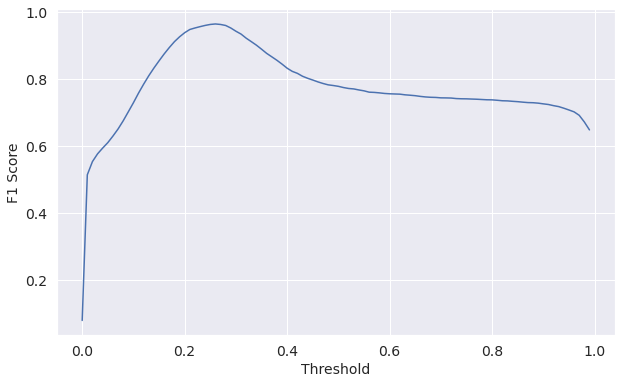

In [20]:
get_optimal_f1_thresh(y_train, y_train_pred)

Best Threshold:  0.38
Best Score:  0.0785137861466039


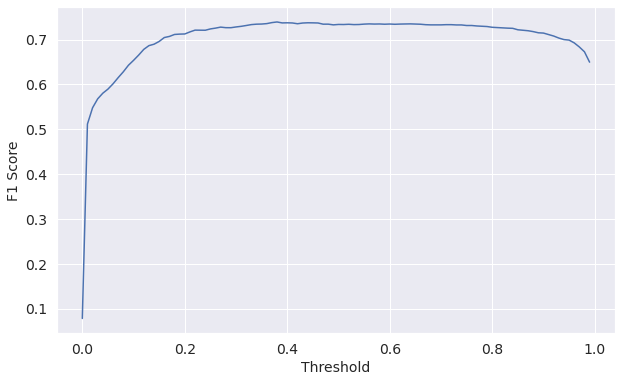

In [21]:
get_optimal_f1_thresh(y_valid, y_valid_pred)

0.4 seems to be the best value according to the graphs

In [22]:
y_test_pred =  clf.predict_proba(X_test)[:, 1]
optimal_thresh = 0.4
y_test_pred_rounded = (y_test_pred > optimal_thresh) * 1
test_score = f1_score(y_test, y_test_pred_rounded, average='macro')
print(test_score)

0.7333087442630031


Values for train,test and valid scores are close to each other, which should be fine.